# Q0 <-> Q5 (coupler) <-> Q1 <-> Q2, Q1 <-> Q3 

In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import numpy as np
import numpy.linalg as alg
import scqubits as scq
import sys
sys.path.insert(0, '..')
from QSwitch import QSwitchTunableTransmonCoupler
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import scipy.constants as cst
hbar = cst.hbar
h = cst.h
qe = cst.e
flux_quant = h/2/qe
red_flux_quant = hbar/2/qe 

# Unit conversions
MHz = 10.0**(-3)
GHz = 1.0
kHz = 10.0**(-6)
us = 10.0**3
ns = 1.0
print(qe)

1.602176634e-19


In [3]:
def EC_GHz_from_C_fF(C_fF):
    return 1e-9 * qe**2 / (2*h*C_fF*1e-15)
def C_fF_from_EC_GHz(EC_GHz):
    return qe**2 / (1e9 * EC_GHz * 2*h*1e-15)

def LJ_H_from_EJ_GHz(EJ_GHz):
    return flux_quant**2 / (h*4*np.pi**2*EJ_GHz*1e9)
    

### Set qubit params

In [955]:
# Q3D VALUES
# All in SI units
# GOOD
Cjs =   np.array([110, 115, 100, 95, 35])*1e-15 # fF -> F
C04 =   12e-15 # between Q0 and coupler pad
C41 =   12e-15 # between Q1 and coupler pad
C01 =   0.07e-15 # direct (parasitic) capacitance between Q0/Q1
Cg =    110e-15 # between each coupler pad and ground
C121 =  10e-15 # between Q1 and Q1/Q2 capacitance bridge
C122 =  10e-15 # between Q2 and Q1/Q2 capacitance bridge
C12g =  50e-15 # between Q1/Q2 capacitance bridge and ground
C12 =   0.07e-15 # direct (parasitic) capacitance between Q1/Q2
C131 =  10e-15 # between Q1 and Q1/Q3 capacitance bridge
C133 =  10e-15 # between Q3 and Q1/Q3 capacitance bridge
C13g =  50e-15 # between Q1/Q3 capacitance bridge and ground
C13 =   0.07e-15 # direct (parasitic) capacitance between Q1/Q3

EJs_targets = np.array([28, 25.5, 31.0, 31.0, 8.4]) # GHz -> these are the Ejs of each junction, or (Ej1+Ej2)/2 for the squid which should be 1/4 of Ejmax_eff of the squid. in the scqubits simulation, need to input Ejmax_eff
dEJ = 0.3 # (EJ1 - EJ2)/(EJ1 + EJ2)

In [956]:
# Variable transformation to combine nodes 1 and 2 to get differential mode describing the tunable coupler
S = np.identity(9)
norm = 1/np.sqrt(2)
S[1, 1] = 1 * norm
S[1, 2] = 1 * norm
S[2, 1] = 1 * norm
S[2, 2] = -1 * norm

In [957]:
EJ1 = EJs_targets[-1] * (dEJ + 1)
EJ2 = EJs_targets[-1] * (1 - dEJ)

Ljs = LJ_H_from_EJ_GHz(EJs_targets)
Lj41 = LJ_H_from_EJ_GHz(EJ1)
Lj42 = LJ_H_from_EJ_GHz(EJ2)

c_matrix = np.zeros((9, 9))
c_matrix[0, 1] = -C04
c_matrix[0, 3] = -C01
c_matrix[0, 8] = -Cjs[0]
c_matrix[1, 2] = -Cjs[4]
c_matrix[1, 8] = -Cg
c_matrix[2, 3] = -C41
c_matrix[2, 8] = -Cg
c_matrix[3, 4] = -C131
c_matrix[3, 5] = -C121
c_matrix[3, 6] = -C12
c_matrix[3, 7] = -C13
c_matrix[3, 8] = -Cjs[1]
c_matrix[4, 7] = -C133
c_matrix[4, 8] = -C13g
c_matrix[5, 6] = -C122
c_matrix[5, 8] = -C12g
c_matrix[6, 8] = -Cjs[2]
c_matrix[7, 8] = -Cjs[3]
c_matrix += c_matrix.transpose()
for i in range(len(c_matrix)):
    c_matrix[i, i] = -sum(c_matrix[i, :])
c_matrix = np.transpose(S) @ c_matrix @ S # basis transformation to use differential mode
c_matrix = c_matrix[:-1, :-1]
# print(c_matrix)


inv_l_matrix = np.zeros((9, 9))
inv_l_matrix[0, 8] = -1/Ljs[0]
inv_l_matrix[1, 2] = -1/Lj41 - 1/Lj42
inv_l_matrix[3, 8] = -1/Ljs[1]
inv_l_matrix[6, 8] = -1/Ljs[2]
inv_l_matrix[7, 8] = -1/Ljs[3]
inv_l_matrix += inv_l_matrix.transpose()
for i in range(len(inv_l_matrix)):
    inv_l_matrix[i, i] = -sum(inv_l_matrix[i, :])
# print(inv_l_matrix)
inv_l_matrix = np.round(np.transpose(S) @ inv_l_matrix @ S, decimals=-5) # basis transformation to use differential mode
inv_l_matrix = inv_l_matrix[:-1, :-1]

q_nodes = [0, 3, 6, 7, 2] # nodes in circuit diagram referring to Q0-4 and differential coupler (Q5) that was originally (node 1 - node 2)/sqrt(2)

print('Check symmetric capacitances:', np.allclose(c_matrix, c_matrix.T))
print('Check symmetric inductances:', np.allclose(inv_l_matrix, inv_l_matrix.T, rtol=1e5))
print('Shapes', c_matrix.shape, inv_l_matrix.shape)

Check symmetric capacitances: True
Check symmetric inductances: True
Shapes (8, 8) (8, 8)


# BEGIN ANALYSIS

In [966]:
inv_c_matrix = alg.inv(c_matrix)

ECs = qe**2/2/h * inv_c_matrix
EJs = flux_quant**2/h/4/np.pi**2 * inv_l_matrix
Zs = np.sqrt(8*np.diag(ECs)/np.diag(EJs))
gs = np.array([[4*ECs[i,j]/np.sqrt(Zs[i]*Zs[j]) for i in range(len(c_matrix))] for j in range(len(c_matrix))])
print('Check symmetric:', np.allclose(gs, gs.T))

print('Index (node) for Qi:', q_nodes)
print('Qubit print order: Q0, Q1, Q2, Q3, Q4 (TC)')
ECs = 1e-9*np.diag(ECs)[q_nodes]
EJs = 1e-9*np.diag(EJs)[q_nodes]
# print('qubit ECs (GHz)\n', ECs)
# print('qubit EJs (GHz)\n', EJs)
# print('all q-q gs (MHz)\n', 1e-6*gs)
# print('q-q gs (MHz)\n', 1e-6*gs[q_nodes][:, q_nodes])
gs = 1e-9 * np.array([gs[0,3], gs[3,6], gs[3,7], gs[0,6], gs[0,7], gs[6,7], gs[0,2], gs[3,2], gs[6,2], gs[7,2]]) # gs=[01, 12, 13, 02, 03, 23, 0c, 1c, 2c, 3c]
print('gs (MHz) [01, 12, 13, 02, 03, 23, 0c, 1c, 2c, 3c]\n', *(1e3*gs))

print('impedances (unitless)\n', *Zs[q_nodes])


"""
For each col, find row with max value, which is the node that it has the most population.
-> use node_pos to reference in EC, EJ
"""
evals_c, u1 = alg.eigh(inv_c_matrix)
u1 = np.array([u1[i]/np.sqrt(evals_c[i]) for i in range(len(evals_c))])
evals, evecs = alg.eigh(u1.transpose() @ inv_l_matrix @ u1)

node_pos = np.array([np.argmax(np.abs(evecs[:, i])) for i in range(len(c_matrix))])
node_counts = np.zeros_like(node_pos)
for m in range(len(c_matrix)):
    node_counts[m] += 1
if any(node_counts != 1): assert False, "Bad mapping of evecs to modes"
print()
print('Qubit modes are mapped (n_evec: n_node):', node_pos)
print('Modes (cols are evecs)\n', np.around(evecs, 3))


# AFTER HERE EVERYTHING IS INDEXED SO QUBIT NUMBER = INDEX AND EVERYTHING IS IN GHz


Check symmetric: False
Index (node) for Qi: [0, 3, 6, 7, 2]
Qubit print order: Q0, Q1, Q2, Q3, Q4 (TC)
gs (MHz) [01, 12, 13, 02, 03, 23, 0c, 1c, 2c, 3c]
 6.066628631923049 35.47397616220911 36.749858604098826 0.08197768293141394 0.08492615100842685 0.49659678203610846 154.81891805977565 -133.2263794015362 -1.800273356310154 -1.8650232776444573
impedances (unitless)
 0.213769730814722 0.20589771394148726 0.21454531170062616 0.2196603026594495 0.15540920141388262

Qubit modes are mapped (n_evec: n_node): [6 7 7 5 4 1 0 2]
Modes (cols are evecs)
 [[ 0.001  0.019 -0.012  0.002  0.002 -0.183  0.976 -0.113]
 [ 0.015  0.343  0.053  0.024  0.027 -0.913 -0.161  0.135]
 [-0.017 -0.454 -0.434  0.022  0.028 -0.276 -0.131 -0.714]
 [-0.092  0.338  0.419 -0.027 -0.66   0.063 -0.048 -0.51 ]
 [-0.15  -0.426 -0.246  0.069 -0.716 -0.136  0.033  0.445]
 [ 0.169 -0.153  0.094 -0.965 -0.035 -0.07  -0.004  0.034]
 [-0.969  0.005  0.043 -0.171  0.171 -0.011 -0.001  0.   ]
 [ 0.026 -0.597  0.75   0.179  0.142 

 C:\Users\slab\AppData\Local\Temp\ipykernel_12368\2067173378.py: 5RuntimeWarning: invalid value encountered in sqrt
 C:\Users\slab\AppData\Local\Temp\ipykernel_12368\2067173378.py: 5

In [965]:
cutoffs = [4, 4, 4, 4, 4]
isCavity = [False]*len(cutoffs)
phi_ext = 0

qram = QSwitchTunableTransmonCoupler(
    EJs=EJs,
    ECs=ECs,
    gs=gs,
    phi_ext=phi_ext,
    is2Q=False,
    cutoffs=cutoffs,
    useZZs=False,
)

qubit_freqs = np.array(qram.qubit_freqs)
alphas = qram.alphas
charge_mat_el = 1/np.sqrt(2) * (EJs/8/ECs)**1/4
# g_rqs = Crqs/(Crqs+Cjs) * res_freqs * np.sqrt(2*Zo/(hbar/qe**2))
# deltas = qubit_freqs-res_freqs
# lamb_shifts = g_rqs**2/deltas
# chi_shifts = g_rqs**2/deltas * alphas/(deltas+alphas)
# drive_purcell_rate_analytical = (2*np.pi*qubit_freqs*1e9*Cds)**2/(Cjs+Cds) * 50 /2/np.pi
# drive_purcell_rate_sim = qubit_freqs*1e9/Q_drives
# kappas = res_freqs/Q_res
# res_purcell_rate = kappas * (g_rqs/deltas)**2

print('EC values (GHz):\n\t', *ECs)
print('EJ values (GHz):\n\t', *EJs)
print('EJ/EC at 0 flux:\n\t', *([*EJs[:-1], qram.EJ_flux(EJs[-1], 0, dEJ)]/ECs))
print('EJ/EC at 0.5 flux:\n\t', *([*EJs[:-1], qram.EJ_flux(EJs[-1], 0.5, dEJ)]/ECs))
print('qubit freqs/2pi (GHz):\n\t', *qubit_freqs)
print('alphas/2pi (GHz):\n\t', *alphas)
print('q-q couplings 01, 12, 13 (MHz)\n\t', *(gs[:3]*1e3))
delta_12 = qubit_freqs[1] - qubit_freqs[2]
delta_13 = qubit_freqs[1] - qubit_freqs[3]
g_eff = 1 / (2*alphas[2]/(0.100*gs[1]*delta_12*(delta_12 - alphas[2])))
print('Q1/Q2 eg-gf 1/g_eff (0.100 GHz drive_strength) (ns)\n\t', 1/g_eff, '\tg_eff (MHz):', 1e3*g_eff)
g_eff = 1 / (2*alphas[1]/(0.100*gs[1]*-delta_12*(-delta_12 - alphas[1])))
print('Q1/Q2 ge-fg 1/g_eff (0.100 GHz drive_strength) (ns)\n\t', 1/g_eff, '\tg_eff (MHz):', 1e3*g_eff)
g_eff = 1 / (2*alphas[3]/(0.100*gs[2]*delta_13*(delta_13 - alphas[3])))
print('Q1/Q3 eg-gf 1/g_eff (0.100 GHz drive_strength) (ns)\n\t', 1/g_eff, '\tg_eff (MHz):', 1e3*g_eff)
g_eff = 1 / (2*alphas[1]/(0.100*gs[2]*-delta_13*(-delta_13 - alphas[1])))
print('Q1/Q3 ge-fg 1/g_eff (0.100 GHz drive_strength) (ns)\n\t', 1/g_eff, '\tg_eff (MHz):', 1e3*g_eff)
print('q-q couplings 02, 03, 23 (MHz)\n\t', *(gs[3:6]*1e3))
print('q-q couplings 0c, 1c, 2c, 3c (MHz)\n\t', *(gs[6:]*1e3))

# print('q-res couplings (MHz) [want 50-100]:\n\t', *(1e3*g_rqs))
# print('delta wq-wr (GHz) [want 1.5-2]:\n\t', *deltas)
# print('lamb shifts (MHz):\n\t', *(1e3*lamb_shifts))
# print('chi shifts (MHz) [want 0.15-0.5]:\n\t', *(1e3*chi_shifts))
# print('\n')
# print('drive purcell limits - analytical (ms) [want >1 ms]:\n\t', *(1e3/drive_purcell_rate_analytical))
# print('drive purcell limits - simulated (ms) [want >1 ms]:\n\t', *(1e3/drive_purcell_rate_sim))
# print('res linewidth kappas - simulated (kHz):\n\t', *(1e6*kappas))
# print('res purcell limits - simulated (s):\n\t', *(1/res_purcell_rate))

EC values (GHz):
	 0.15994670972869307 0.13513043497439256 0.1783207644393659 0.1869248389955692 0.10146169068518038
EJ values (GHz):
	 28.00095714380162 25.49999599785787 30.992302828165716 30.992302828165716 33.607687033074214
EJ/EC at 0 flux:
	 175.06428979563117 188.70653382186003 173.80086343620388 165.80088015429746 331.23523574383916
EJ/EC at 0.5 flux:
	 175.06428979563117 188.70653382186003 173.80086343620388 165.80088015429746 99.37057072315176
qubit freqs/2pi (GHz):
	 5.8212036879198905 5.111522878776171 6.465776499038764 6.615309462295578 5.119402861371704
alphas/2pi (GHz):
	 -0.1709302993702373 -0.14401984849943972 -0.1906171311391578 -0.2001687649135846 -0.10633265483846799
q-q couplings 01, 12, 13 (MHz)
	 6.066628631923049 35.47397616220911 36.749858604098826
Q1/Q2 eg-gf 1/g_eff (0.100 GHz drive_strength) (ns)
	 -68.19691329421774 	g_eff (MHz): -14.663420259004416
Q1/Q2 ge-fg 1/g_eff (0.100 GHz drive_strength) (ns)
	 -40.01763153886981 	g_eff (MHz): -24.988985143428167
Q1

# Tunable transmon

In [960]:
from PulseSequence import PulseSequence
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('default')
plt.rcParams['figure.figsize'] = [9.7, 6]
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
linestyle_cycle=['solid', 'dashed', 'dotted', 'dashdot']
marker_cycle = [None, 'o', '.', 's', '*', '^']

In [961]:
cutoffs = [4]*5

print('AT FLUX 0')
phi_ext = 0.0
qram = QSwitchTunableTransmonCoupler(
    EJs=EJs,
    ECs=ECs,
    dEJ=dEJ,
    gs=gs,
    phi_ext=phi_ext,
    is2Q=False,
    cutoffs=cutoffs,
    useZZs=False,
)

qubit_freqs = qram.qubit_freqs
alphas = qram.alphas
print('bare qubit freqs (GHz)', *qubit_freqs)
print('bare alphas (GHz)', *alphas)
print(f'EJ/EC', *([*EJs[:-1], qram.EJ_flux(phi_ext=phi_ext)]/ECs))

# print('capacitances (fF)', *(qe**2/(2*h*np.array(ECs)*1e9)*1e15))
# print('lumped L (nH)', *(red_flux_quant**2/h/np.array(EJs)))

print()
print('AT FLUX 0.5')
phi_ext = 0.5
qram = QSwitchTunableTransmonCoupler(
    EJs=EJs,
    ECs=ECs,
    dEJ=dEJ,
    gs=gs,
    phi_ext=phi_ext,
    is2Q=False,
    cutoffs=cutoffs,
    useZZs=False,
)

qubit_freqs = qram.qubit_freqs
alphas = qram.alphas
print('bare qubit freqs (GHz)', *qubit_freqs)
print('bare alphas (GHz)', *alphas)
print(f'EJ/EC', *([*EJs[:-1], qram.EJ_flux(phi_ext=phi_ext)]/ECs))


AT FLUX 0
bare qubit freqs (GHz) 5.8212036879198905 5.111522878776171 6.465776499038764 6.615309462295578 5.119402861371704
bare alphas (GHz) -0.1709302993702373 -0.14401984849943972 -0.1906171311391578 -0.2001687649135846 -0.10633265483846799
EJ/EC 175.06428979563117 188.70653382186003 173.80086343620388 165.80088015429746 331.23523574383916

AT FLUX 0.5
bare qubit freqs (GHz) 5.8212036879198905 5.111522878776171 6.465776499038764 6.615309462295578 2.7552777063457103
bare alphas (GHz) -0.1709302993702373 -0.14401984849943972 -0.1906171311391578 -0.2001687649135846 -0.11118787440422118
EJ/EC 175.06428979563117 188.70653382186003 173.80086343620388 165.80088015429746 99.37057072315176


### Minimize ZZ

In [962]:
ZZ_01_flux = []
ZZ_01_fe_flux = []
ZZ_21_flux = []
ZZ_31_flux = []
ZZ_23_flux = []
# phi_exts = np.linspace(-0.25, 0.75, num=61)
phi_exts = np.linspace(-0.25, 0.75, num=21)
print(phi_exts)
evals_flux = []
esys_flux = []
qubit_freqs_v_flux = np.zeros(shape=(qram.nqubits, 2, len(phi_exts)))
plot_levels = ['efggg', 'gfggg']
plot_levels_wds = [[], []]

for i_phi, phi_ext_i in enumerate(tqdm(phi_exts)):
    qram = QSwitchTunableTransmonCoupler(
        EJs=EJs,
        ECs=ECs,
        dEJ=dEJ,
        phi_ext=phi_ext_i,
        gs=gs,
        is2Q=False,
        cutoffs=cutoffs,
        useZZs=False,
    )
    evals, evecs = qram.esys
    evals_flux.append(evals)
    esys_flux.append(qram.esys)
    ZZ_01_flux.append(qram.get_ZZ(1, 0, qA_state='e', qB_state='e'))
    ZZ_01_fe_flux.append(qram.get_ZZ(1, 0, qA_state='f', qB_state='e'))
    ZZ_21_flux.append(qram.get_ZZ(1, 2, qA_state='e', qB_state='e'))
    ZZ_31_flux.append(qram.get_ZZ(1, 3, qA_state='e', qB_state='e'))
    ZZ_23_flux.append(qram.get_ZZ(2, 3, qA_state='e', qB_state='e'))
    for q in range(5):
        gstate = 'ggggg'
        estate = gstate[:q] + 'e' + gstate[q+1:]
        fstate = gstate[:q] + 'f' + gstate[q+1:]
        qubit_freqs_v_flux[q][0][i_phi] = qram.get_base_wd(gstate, estate)
        qubit_freqs_v_flux[q][1][i_phi] = qram.get_base_wd(gstate, fstate)
        # print(qubit_freqs_v_flux)
    for i, level in enumerate(plot_levels):
        wds = plot_levels_wds[i]
        wds.append(qram.get_base_wd('ggggg', level))

ZZ_01_flux = np.array(ZZ_01_flux)
ZZ_21_flux = np.array(ZZ_21_flux)
ZZ_31_flux = np.array(ZZ_31_flux)
ZZ_23_flux = np.array(ZZ_23_flux)
ZZ_01_fe_flux = np.array(ZZ_01_fe_flux)
evals_flux = np.array(evals_flux)
qubit_freqs_v_flux = np.array(qubit_freqs_v_flux)
plot_levels_wds = np.array(plot_levels_wds)

[-0.25 -0.2  -0.15 -0.1  -0.05  0.    0.05  0.1   0.15  0.2   0.25  0.3
  0.35  0.4   0.45  0.5   0.55  0.6   0.65  0.7   0.75]


100%|██████████| 21/21 [00:24<00:00,  1.14s/it]


Q0/Q1 e states ZZ (MHz)
	Min ZZ -0.008134876385845757 at phi_ext/phi0 0.5
	Max ZZ -14.707917695999662 at phi_ext/phi0 0.0
Q0 e/Q1 f ZZ (MHz)
	Min ZZ -0.016205449576034425 at phi_ext/phi0 0.5
	Max ZZ -20.8723534660038 at phi_ext/phi0 0.0
Q2/Q1 e states ZZ (MHz)
	Min ZZ -0.298647476538072 at phi_ext/phi0 0.0
	Max ZZ -0.48236507224075353 at phi_ext/phi0 0.4
Q3/Q1 e states ZZ (MHz)
	Min ZZ -0.26565553920399054 at phi_ext/phi0 0.0
	Max ZZ -0.4352586505387279 at phi_ext/phi0 0.4


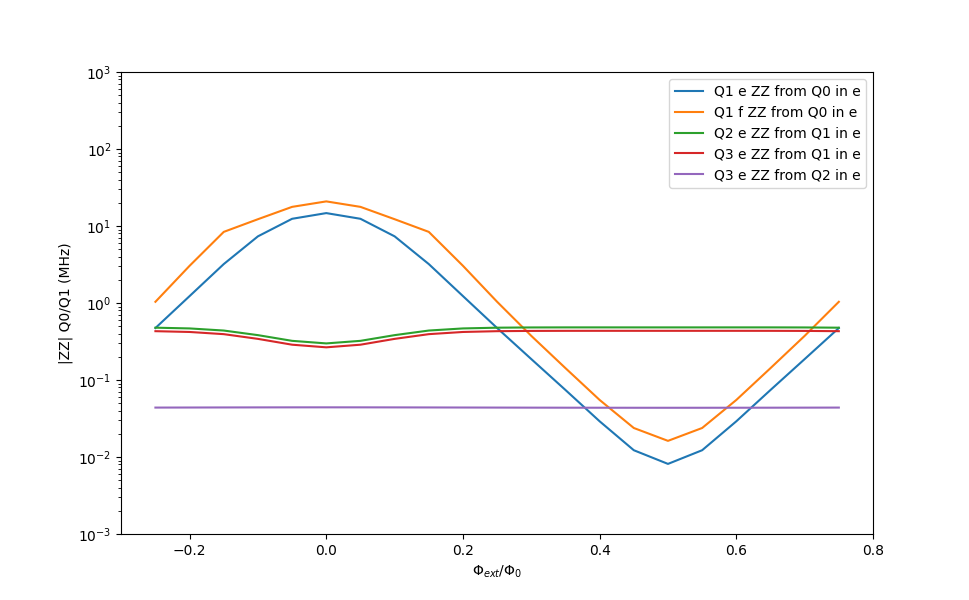

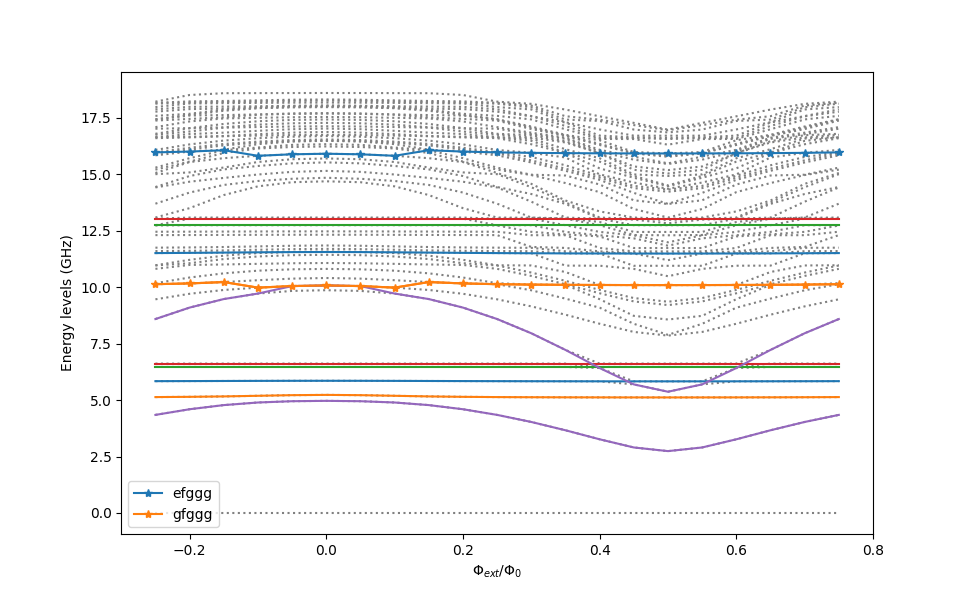

In [967]:
print('Q0/Q1 e states ZZ (MHz)')
i_flux_min_ZZ = np.argmin(np.abs(ZZ_01_flux))
print('\tMin ZZ', 1e3*ZZ_01_flux[i_flux_min_ZZ], 'at phi_ext/phi0', phi_exts[i_flux_min_ZZ])
i_flux_max_ZZ = np.argmax(np.abs(ZZ_01_flux))
print('\tMax ZZ', 1e3*ZZ_01_flux[i_flux_max_ZZ], 'at phi_ext/phi0', phi_exts[i_flux_max_ZZ])

print('Q0 e/Q1 f ZZ (MHz)')
i_flux_min_ZZ = np.argmin(np.abs(ZZ_01_fe_flux))
print('\tMin ZZ', 1e3*ZZ_01_fe_flux[i_flux_min_ZZ], 'at phi_ext/phi0', phi_exts[i_flux_min_ZZ])
i_flux_max_ZZ = np.argmax(np.abs(ZZ_01_fe_flux))
print('\tMax ZZ', 1e3*ZZ_01_fe_flux[i_flux_max_ZZ], 'at phi_ext/phi0', phi_exts[i_flux_max_ZZ])

print('Q2/Q1 e states ZZ (MHz)')
i_flux_min_ZZ = np.argmin(np.abs(ZZ_21_flux))
print('\tMin ZZ', 1e3*ZZ_21_flux[i_flux_min_ZZ], 'at phi_ext/phi0', phi_exts[i_flux_min_ZZ])
i_flux_max_ZZ = np.argmax(np.abs(ZZ_21_flux))
print('\tMax ZZ', 1e3*ZZ_21_flux[i_flux_max_ZZ], 'at phi_ext/phi0', phi_exts[i_flux_max_ZZ])

print('Q3/Q1 e states ZZ (MHz)')
i_flux_min_ZZ = np.argmin(np.abs(ZZ_31_flux))
print('\tMin ZZ', 1e3*ZZ_31_flux[i_flux_min_ZZ], 'at phi_ext/phi0', phi_exts[i_flux_min_ZZ])
i_flux_max_ZZ = np.argmax(np.abs(ZZ_21_flux))
print('\tMax ZZ', 1e3*ZZ_31_flux[i_flux_max_ZZ], 'at phi_ext/phi0', phi_exts[i_flux_max_ZZ])

plt.figure()
plt.plot(phi_exts, abs(ZZ_01_flux)*1e3, label='Q1 e ZZ from Q0 in e')
plt.plot(phi_exts, abs(ZZ_01_fe_flux)*1e3, label='Q1 f ZZ from Q0 in e')
plt.plot(phi_exts, abs(ZZ_21_flux)*1e3, label='Q2 e ZZ from Q1 in e')
plt.plot(phi_exts, abs(ZZ_31_flux)*1e3, label='Q3 e ZZ from Q1 in e')
plt.plot(phi_exts, abs(ZZ_23_flux)*1e3, label='Q3 e ZZ from Q2 in e')
plt.axhline(0, linestyle='--', color='0.2')
plt.legend()
plt.ylim(1e-3, 1e3)
plt.yscale('log')
plt.xlabel('$\Phi_{ext}/\Phi_0$')
plt.ylabel('|ZZ| Q0/Q1 (MHz)')
plt.show()


plt.figure()
nlevels = 50
for level in range(nlevels):
    plt.plot(phi_exts, evals_flux[:, level]/2/np.pi, linestyle='dotted', color='0.5')
for q in range(len(qubit_freqs)):
    for level in range(qubit_freqs_v_flux.shape[1]):
            plt.plot(phi_exts, qubit_freqs_v_flux[q, level, :]/2/np.pi, default_colors[q])
for plot_level_name, wds in zip(plot_levels, plot_levels_wds):
    plt.plot(phi_exts, wds/2/np.pi, '*-', label=plot_level_name)
plt.legend()
plt.xlabel('$\Phi_{ext}/\Phi_0$')
plt.ylabel('Energy levels (GHz)')
plt.show()


# plt.figure()
# # plt.plot(phi_exts, wc_flux/2/np.pi, label='$f_{coupler}$')
# # plt.plot(phi_exts, dwcdflux/2/np.pi, label='$df_{coupler}/d\Phi$')
# plt.plot(phi_exts, 1e3*Omega_eff_flux, label='iSWAP $\Omega_{eff}$')
# # plt.plot(phi_exts, 1/(Del_0minus_flux * Del_1minus_flux))
# plt.axhline(0, linestyle='--', color='0.2')
# plt.xlabel('$\Phi_{ext}/\Phi_0$')
# plt.ylabel('iSWAP rate (MHz)')
# plt.legend()
# plt.show()